## 第 5 章 误差反向传播法
1. 计算图
2. 链式法则
3. 反向传播
4. 简单层的实现
5. 激活函数层的实现
6. Affine/Softmax 层的实现
7. 误差反向传播法的实现
8. 小结

### 5.1 计算图: 
*计算图将计算过程用图形表示出来, 这里说的图形是数据结构图，通过多个节点和边表示*
- 5.1.1 **用计算图求解**: 从左向右进行计算, 为正向传播(forward propagation); 从右向左, 反向传播(backward propagation), 导数计算
- 5.1.2 **局部计算**: 与自己相关的某个小范围, 无论全局发生了什么，都能只根据与自己相关的信息输出接下来的结果。
- 5.1.3 **为何用计算图解题**: 通过反向传播高效计算导数。(局部计算 + 利用计算图可以将中间的计算结果全部保存起来)

### 5.2 链式法则: 
将局部导数向正方向的反方向（从右到左）传递, 传递这个局部导数的原理，是基于链式法则(chain rule)的。
- 5.2.1 **计算图的反向传播**: 将信号 E 乘以节点的局部导数$(\frac{∂y}{∂x})$，然后将结果传递给下一个节点。假设 $y=f(x)=x^2$, 则局部导数为$(\frac{∂y}{∂x})$=2x. 把这个局部导数乘以上游传过来的值(本例中为 E)，然后传递给前面的节点。这就是反向传播的计算顺序。通过这样的计算，可以高效地求出导数的值，这是反向传播的要点。
- 5.2.2 **什么是链式法则**: 从复合函数说起, 复合函数是由多个函数构成的函数。比如，$z = (x + y)^2$ 是由 $z = t^2$, $t = x + y$ 两个式子构成的。如果某个函数由复合函数表示，则该复合函数的导数可以用构成复合函数的各个函数的导数的乘积表示。$(\frac{∂z}{∂x} = \frac{∂z}{∂t} · \frac{∂t}{∂x})$ ∂t 正好可以互相抵消。$(\frac{∂z}{∂t} = 2t, \frac{∂t}{∂x} = 1, 2t · 1 = 2(x + y)$。
- 5.2.3 **链式法则和计算图**: 计算图的反向传播从右到左传播信号。反向传播的计算顺序是，先将节点的输入信号乘以节点的局部导数（偏导数），然后再传递给下一个节点。

### 5.3 反向传播
加法的反向传播只是将上游的值传给下游，并**不需要**正向传播的输入信号。但是，乘法的反向传播**需要**正向传播时的输入信号值。因此，实现乘法节点的反向传播时，要**保存正向传播**的输入信号。
- 5.3.1 **加法节点的反向传播**: $z = x + y$ 加法节点的反向传播只是将输入信号输出到下一个节点。
- 5.3.2 **乘法节点的反向传播**: $z = x · y$ 乘法的反向传播会将上游的值乘以正向传播时的输入信号的“翻转值”后传递给下游。
- 5.3.3 **苹果的例子**

### 5.4 简单层的实现
- 乘法层(MulLayer)
- 加法层(AddLayer)
- 这里所说的“层”是神经网络中功能的单位。比如，负责 sigmoid 函数的Sigmoid、负责矩阵乘积的 Affine等，都以层为单位进行实现。

#### 5.4.1 乘法层的实现

In [1]:
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None

    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        return out

    def backward(self, dout):
        dx = dout * self.y
        dy = dout * self.x
        return dx, dy

In [2]:
# 使用2过苹果的例子，买2个苹果，单价100，税率1.1。求最后总价对于这三个元素的导数
apple_each = 100
apple_num = 2
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

In [3]:
# forward
apple_cost = mul_apple_layer.forward(apple_each, apple_num)
total_pay = mul_tax_layer.forward(apple_cost, tax)
print(apple_cost, total_pay)

200 220.00000000000003


In [4]:
# backward
dpay = 1
dapple_cost, dtax = mul_tax_layer.backward(dpay)
dapple_each, dapple_num = mul_apple_layer.backward(dapple_cost)
print(dapple_each, dapple_num, dtax)

2.2 110.00000000000001 200


#### 5.4.2 加法层的实现

In [5]:
class AddLayer:
    def __init__(self):
        pass

    def forward(self, x, y):
        out = x + y
        return out

    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [6]:
# 购买2个苹果(100)和3个橘子(150)
apple_each = 100
orange_each = 150
apple_num = 2
orange_num = 3
tax = 1.1

# Layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

In [7]:
# forward
apple_cost = mul_apple_layer.forward(apple_each, apple_num)
orange_cost = mul_orange_layer.forward(orange_each, orange_num)
all_cost = add_apple_orange_layer.forward(apple_cost, orange_cost)
final_pay = mul_tax_layer.forward(all_cost, tax)
print(apple_cost, orange_cost, all_cost, int(final_pay))

200 450 650 715


In [8]:
# backward
dpay = 1
dall_cost, dtax = mul_tax_layer.backward(dpay)
dapple_cost, dorange_cost = add_apple_orange_layer.backward(dall_cost)
dorange_each, dorange_num = mul_orange_layer.backward(dorange_cost)
dapple_each, dapple_num = mul_apple_layer.backward(dapple_cost)

print(f'dtax: {dtax}')
print(f'dall_cost: {dall_cost}')
print(f'dapple_cost: {dapple_cost}')
print(f'dorange_cost: {dorange_cost}')
print(f'dorange_each: {round(dorange_each, 10)}')
print(f'dorange_num: {int(dorange_num)}')
print(f'dapple_each: {dapple_each}')
print(f'dapple_num: {int(dapple_num)}')

dtax: 650
dall_cost: 1.1
dapple_cost: 1.1
dorange_cost: 1.1
dorange_each: 3.3
dorange_num: 165
dapple_each: 2.2
dapple_num: 110


### 5.5 激活函数层的实现

#### 5.5.1 ReLU层
$y = \begin{cases} x, & x > 0 \\ 0, & x \le 0 \end{cases}$ ， 
$\frac{\partial y}{\partial x} = \begin{cases} 1, & x > 0 \\ 0, & x \le 0 \end{cases}$  
如果正向传播时的输入 x 大于 0，则反向传播会将上游的值原封不动地传给下游。  
反过来，如果正向传播时的 x 小于等于 0，则反向传播中传给下游的信号将**停在此处**。

In [9]:
import numpy as np

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)  # 记录哪些位置≤0
        out = x.copy()        # 复制输入
        out[self.mask] = 0    # 将≤0的位置设为0
        return out

    def backward(self, dout):
        dout[self.mask] = 0   # 将mask标记的位置梯度设为0
        dx = dout
        return dx

In [10]:
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
relu = Relu()

# 正向传播时保存反向传播需要的信息，标记了x中小于0的位置在mask中。在前向传播时精心设计，为反向传播做好准备
out = relu.forward(x)
print("=== 前向传播 ===")
print(f"输入: \n {x}")
print(f"mask: \n {relu.mask}")
print(f"输出: \n {out}")

# 正向传播时为0的位置，反向传播时仍为0，其他位置值不变直接传递
print("\n=== 反向传播 ===")
dout = np.array([[0.5, 1.0], [2.0, 0.8]])
print(f"上游梯度: \n {dout}")
dx = relu.backward(dout)
print(f"本地梯度: \n {dx}")

=== 前向传播 ===
输入: 
 [[ 1.  -0.5]
 [-2.   3. ]]
mask: 
 [[False  True]
 [ True False]]
输出: 
 [[1. 0.]
 [0. 3.]]

=== 反向传播 ===
上游梯度: 
 [[0.5 1. ]
 [2.  0.8]]
本地梯度: 
 [[0.5 0. ]
 [0.  0.8]]


#### 5.5.2 Sigmoid层
$y = σ(x) = \frac{1}{1 + exp(-x)}$ , 那么y对x求导，结果为：$\frac{dy}{dx} = y·(1 - y)$


In [11]:
def Sigmoid(x):
    def __init__(self):
        self.out = None

    def forward(self, x):
        y = 1 / (1 + np.exp(-x))
        self.out = y    # 将输出保存
        return y

    def backward(self, dout):
        dx = dout * self.out * (1 - self.out)
        return dx

### 5.6 Affine/Softmax 层的实现

#### 5.6.1 Affine层
- 神经元的**加权总和** $Y = X \cdot W + B$, 然后 Y 经过激活函数转换后，传递给下一层。这就是神经网络正向传播的流程。
- 神经网络的正向传播中进行的矩阵的乘积运算在几何学领域被称为“仿射变换”,因此，这里将进行仿射变换的处理实现为“Affine 层”。
$$ \frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot W^T $$
$$ \frac{\partial L}{\partial W} = X^T \cdot \frac{\partial L}{\partial Y} $$
$$ W = \begin{pmatrix} w_{11} & w_{12} & w_{13} \\ w_{21} & w_{22} & w_{23} \end{pmatrix}$$
$$ W^T = \begin{pmatrix} w_{11} & w_{21} \\ w_{12} & w_{22} \\ w_{13} & w_{23} \end{pmatrix}$$
- 如果 $W$ 的形状是 (2, 3)，$W^T$ 的形状就是 (3, 2)
- X 和 $\frac{\partial L}{\partial X}$ 形状相同 (2,)
- W 和 $\frac{\partial L}{\partial W}$ 形状相同 (2, 3)

#### 5.6.2 批版本的Affine层
前面介绍的 Affine 层的输入 X 是以单个数据为对象的。现在我们考虑 N个数据一起进行正向传播的情况，也就是批版本的 Affine 层。  
$\frac{\partial L}{\partial X} = \frac{\partial L}{\partial Y} \cdot W^T$ ------ 
$\frac{\partial L}{\partial W} = X^T \cdot \frac{\partial L}{\partial Y}$ ------ 
$\frac{\partial L}{\partial B} = \frac{\partial L}{\partial Y}$  
(N,2) = (N,3)·(3,2) ----- (2,3) = (2,N)·(N,3) ----- (3) = (N,3)

In [12]:
# 偏置B的反向传播值为第一个轴（第 0 轴）方向上的和，即 dB = np.sum(dY, axis=0)
X_dot_W = np.array([[0, 0, 0], [10, 10, 10]])
B = np.array([1, 2, 3])
print(X_dot_W)
print(X_dot_W + B)
print()

dY = np.array([[1, 2, 3,], [4, 5, 6]])
dB = np.sum(dY, axis=0)
print(dY)
print(dB)

[[ 0  0  0]
 [10 10 10]]
[[ 1  2  3]
 [11 12 13]]

[[1 2 3]
 [4 5 6]]
[5 7 9]


In [13]:
class Affine:
    """
    Affine层要求二维输入:(batch_size, features)
    图像数据通常是多维的: (batch_size, height, width, channels)
    reshape(x.shape[0], -1) 的含义：
    x.shape[0]：保持批量大小不变
    -1：让NumPy自动计算其他维度展平后的长度

    比如 x = np.random.rand(2, 3, 4, 5), 
    print(x.shape)  # (2, 3, 4, 5)
    x = x.reshape(x.shape[0], -1)
    print(x.shape)  # (2, 60)
    x.shape[0]代表输入数据个数，这里是2 代表2条数据；后面的60表示特征features

    维度匹配规则:
    输入x: (batch_size=2, 3, 4)
    输入x: (batch_size, 12)   # reshape 3×4=12
    权重W: (12, output_dim=10)   # 必须匹配！
    偏置b: (output_dim=10,)
    输出: (batch_size, output_dim) # (2, 10)
    """
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        self.original_x_shape = None           # 记录原始形状

    def forward(self, x):
        self.original_x_shape = x.shape        # 记录原始形状（用于处理非矩阵输入）
        self.x = x.reshape(x.shape[0], -1)     # 展平为矩阵
        out = np.dot(self.x, self.W) + self.b
        return out

    def backward(self, dout):
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        dx = np.dot(dout, self.W.T)
        dx = dx.reshape(self.original_x_shape) # 恢复原始形状
        return dx

#### 5.6.3 Softmax-with-Loss 层
- softmax 函数会将输入值正规化之后再输出。比如手写数字识别时, 输入图像通过Aﬃ ne 层和ReLU 层进行转换，10 个输入通过Softmax 层进行正规化。“0”的得分是 5.3，这个值经过 Softmax 层转换为 0.008（ 0.8% ）；“2”的得分是10.1，被转换为0.991 （ 99.1% ）
- Softmax 层将输入值正规化（将输出值的和调整为 1 ）之后再输出。另外，因为手写数字识别要进行 10 类分类，所以向 Softmax 层的输入也有 10 个。
- 考虑到这里也包含作为损失函数的交叉熵误差（ cross entropy error ），所以称为“Softmax-with-Loss 层”
- Softmax 层的反向传播得到了（ y1 − t1, y2 − t2, y3 − t3 ）这样“漂亮”的结果。由于（ y1, y2, y3 ）是 Softmax 层的输出，（ t1, t2, t3 ）是监督数据，所以（ y1 − t1, y2 − t2, y3 − t3 ）是Softmax层的输出和监督标签的**差分**。神经网络的反向传播会把这个**差分**表示的**误差**传递给前面的层，这是神经网络学习中的重要性质。
- 当神经网络未能进行正确的识别，此时，Softmax 层的反向传播传递的是(0.3,−0.8, 0.5) 一个大的误差，因为这个大的误差会向前面的层传播，所以 Softmax 层前面的层会从这个大的误差中学习到“大”的内容。反之，如果神经网络识别得相当准确，时 Softmax 层的反向传播传递的是 (0.01,−0.01, 0) 这样一个小的误差。这个小的误差也会向前面的层传播，因为误差很小，所以 Softmax 层前面的层学到的内容也很“小”。
- 神经网络学习的目的就是通过调整**权重参数**，使神经网络的输出（Softmax的输出）接近监督标签。
- 神经网络中进行的处理有**推理** （inference）和**学习**两个阶段。推理通常不使用 Softmax 层, 会将最后一个 Affine 层的输出作为识别结果, 被称为“**得分**”。也就是说，当神经网络的推理只需要给出一个答案的情况下，因为此时只对得分**最大值**感兴趣，所以不需要 Softmax 层。不过，神经网络的学习阶段则需要 Softmax 层, 因为要计算损失函数的值loss。

In [14]:
from common.functions import softmax, cross_entropy_error

class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None   # 损失
        self.y = None      # softmax的输出
        self.t = None      # 监督数据（ one-hot vector）
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size
        return dx

### 5.7 误差反向传播法的实现

#### 5.7.1 神经网络学习的全貌图
- 前提:神经网络中有合适的权重和偏置，调整权重和偏置以便拟合训练数据的过程称为学习。神经网络的学习分为下面4个步骤。误差反向传播法会在步骤2中出现。和需要花费较多时间的数值微分不同，误差反向传播法可以快速高效地计算梯度。
1. mini-batch: 从训练数据中随机选择一部分数据。
2. 计算梯度: 计算损失函数关于各个权重参数的梯度。
3. 更新参数: 将权重参数沿梯度方向进行微小的更新。
4. 重复: 重复步骤 1、步骤 2、步骤 3。

#### 5.7.2 对应误差反向传播法的神经网络的实现
- 每个层都精心保存了反向传播需要的信息：
    - Affine层: 保存输入x (用于计算dW = x.T · dout)
    - ReLU层: 保存mask (用于梯度阻断)  
    - Sigmoid层: 保存输出out (用于梯度计算)
    - Softmax层: 保存y和t (用于梯度简化)

- 每个层的反向传播都对应简洁的数学公式：
    - Affine: dx = dout · Wᵀ, dW = xᵀ · dout, db = sum(dout)
    - ReLU: dx = dout * (x > 0)
    - Sigmoid: dx = dout * (1 - out) * out
    - SoftmaxWithLoss: dx = (y - t) / batch_size

In [15]:
from collections import OrderedDict
from common.layers import Relu, Affine, SoftmaxWithLoss
from common.gradient import numerical_gradient

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 初始化权重
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['b2'] = np.zeros(output_size)

        # 生成层
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.lastLayer = SoftmaxWithLoss() # 此设计允许灵活替换损失函数，如回归任务 self.lastLayer = MSELoss()
    
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x # 第三轮: Affine2.forward(x), np.dot(x, W2) + b2 → 形状: (batch_size, output_size)

    def loss(self, x, t):
        y = self.predict(x)  # y = Affine2的输出（得分），未计算softmax概率
        return self.lastLayer.forward(y, t)  # 最后一层先softmax计算预测的的概率y，再与真值t通过交叉熵算出loss
        
    def accuracy(self, x, t):
        y = self.predict(x)       # 加权输入总和
        y = np.argmax(y, axis=1)  # 每个数据中最大值对应位置索引
        if t.ndim != 1 : t = np.argmax(t, axis=1) # 如果t是one-hot-vector，转成整数标签形式
        return np.sum(y == t) / x.shape[0]  # 比较预测值与真实标签一致性在全体数据中的占比

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)  # 一个闭包：它记住了当前的x和t值，此处定义函数但不执行，传递给numerical_gradient里面再执行
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        return grads

    def gradient(self, x, t):
        """
        只需2次传播: 直接计算出所有39,760个梯度
        1次前向传播: 输入x → Affine1 → ReLU1 → Affine2 → Softmax → 损失值
        1次反向传播: dout=1 → SoftmaxWithLoss → Affine2 → ReLU1 → Affine1
        """
        # forward
        self.loss(x, t) 
        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        # store gradient
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        return grads

    # 🆕 新增的模型保存和加载方法
    def save_model(self, filepath):
        """保存模型参数到文件"""
        with open(filepath, 'wb') as f:
            pickle.dump(self.params, f)
        print(f"模型已保存到: {filepath}")

    def load_model(self, filepath):
        """从文件加载模型参数"""
        with open(filepath, 'rb') as f:
            self.params = pickle.load(f)
        print(f"模型已从 {filepath} 加载")
        # 🎯 重要：重新初始化网络层，使用加载的参数
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        # # 使用示例：
        # # 训练完成后保存模型
        # network = TwoLayerNet(784, 50, 10)
        # # ... 训练代码
        # network.save_model('trained_model.pkl')

        # # 之后可以加载模型进行推理
        # new_network = TwoLayerNet(784, 50, 10)  # 创建相同结构的网络
        # new_network.load_model('trained_model.pkl')

        # # 现在可以直接使用训练好的模型进行预测
        # test_acc = new_network.accuracy(x_test, t_test)
        # print(f"加载模型的测试准确率: {test_acc:.2%}")

#### 5.7.3 误差反向传播法的梯度确认
数值微分的计算很耗费时间, 数值微分的优点是实现简单，因此，一般情况下不太容易出错。而误差反向传播法的实现很复杂，容易出错。所以，经常会比较数值微分的结果和误差反向传播法的结果，以确认误差反向传播法的实现是否正确。确认数值微分求出的梯度结果和误差反向传播法求出的结果是否一致（严格地讲，是非常相近）的操作称为梯度确认 （ gradient check ）。

In [16]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

x_batch = x_train[:3]
t_batch = t_train[:3]

network = TwoLayerNet(784, 50, 10)
grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)
# 求各个权重的绝对误差的平均值
for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_numerical[key] - grad_backprop[key]))
    print(f'{key} : {str(diff)}')

W1 : 2.408970257469408e-07
b1 : 4.066413758015701e-06
W2 : 6.128437764066959e-09
b2 : 1.3996703377289198e-07


In [17]:
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=False)

x_batch = x_train[-3:]
t_batch = t_train[-3:]

network = TwoLayerNet(784, 50, 10)
grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

for key in grad_numerical.keys():
    diff = np.average(np.abs(grad_numerical[key] - grad_backprop[key]))
    print(f'{key} : {str(diff)}')

W1 : 3.1245288020246864e-10
b1 : 2.1197721460531216e-09
W2 : 4.807788597218176e-09
b2 : 1.395902058068388e-07


#### 5.7.4 使用误差反向传播法的学习
跟*4.5.3 基于测试数据的评价*一样

In [18]:
# Load data
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label = True)
# Initialize network
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)
# 超参数
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []
# 平均每个 epoch的重复次数 (即需要这么多次才能把所有数据都用完一轮)
iter_per_epoch = max(train_size / batch_size, 1)    # 60000 / 100 = 600.0

for i in range(iters_num):
    # 可以动态调整学习率
    if i > 5000 : learning_rate = 0.01  # 后期减小学习率
    # 1. Get mini_batch
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 2. Calculate gradient
    # grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 3. Update params
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
        
    # Record learning process
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # Record training / test accuracy for each epoch
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(f'Epoch {i // iter_per_epoch + 1}: train acc, test acc | {train_acc:.2%}, {test_acc:.2%}')


Epoch 1.0: train acc, test acc | 8.86%, 8.94%
Epoch 2.0: train acc, test acc | 90.06%, 90.29%
Epoch 3.0: train acc, test acc | 92.31%, 92.51%
Epoch 4.0: train acc, test acc | 93.55%, 93.55%
Epoch 5.0: train acc, test acc | 94.06%, 93.93%
Epoch 6.0: train acc, test acc | 95.06%, 94.97%
Epoch 7.0: train acc, test acc | 95.72%, 95.26%
Epoch 8.0: train acc, test acc | 96.03%, 95.57%
Epoch 9.0: train acc, test acc | 96.43%, 95.88%
Epoch 10.0: train acc, test acc | 96.65%, 96.22%
Epoch 11.0: train acc, test acc | 96.70%, 96.18%
Epoch 12.0: train acc, test acc | 96.74%, 96.14%
Epoch 13.0: train acc, test acc | 96.74%, 96.19%
Epoch 14.0: train acc, test acc | 96.77%, 96.26%
Epoch 15.0: train acc, test acc | 96.81%, 96.25%
Epoch 16.0: train acc, test acc | 96.82%, 96.28%
Epoch 17.0: train acc, test acc | 96.87%, 96.34%


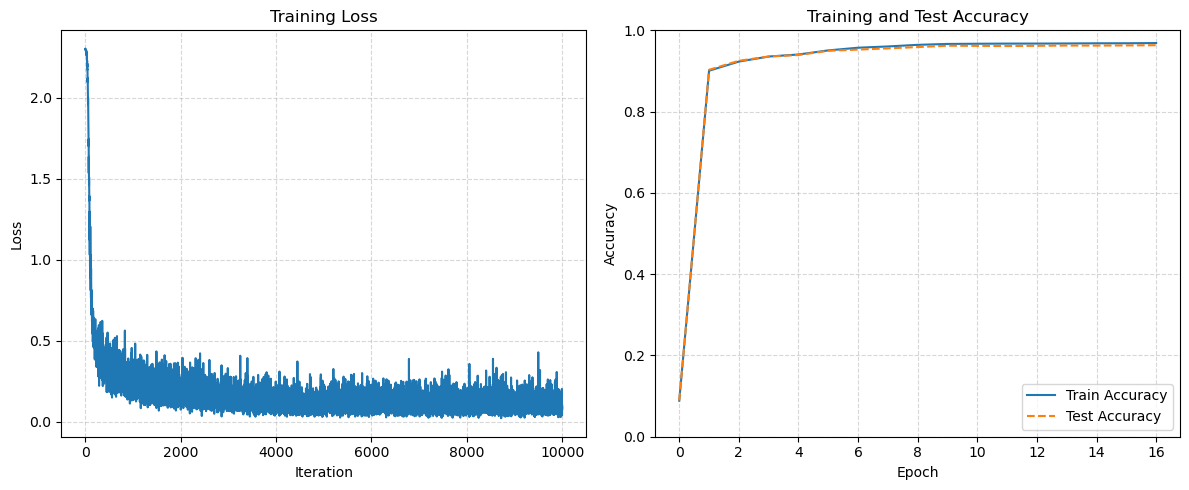

In [19]:
# 绘制损失函数和训练/测试准确率的图形
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))  # 设置图形大小
# 左子图：损失函数
plt.subplot(1, 2, 1)  # 1行2列的第1个图
x_loss = np.arange(len(train_loss_list))
plt.plot(x_loss, train_loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True, linestyle='--', alpha=0.5)
# 右子图：准确率
plt.subplot(1, 2, 2)  # 1行2列的第2个图
x_acc = np.arange(len(train_acc_list))
plt.plot(x_acc, train_acc_list, label='Train Accuracy')
plt.plot(x_acc, test_acc_list, label='Test Accuracy', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1.0)
plt.title('Training and Test Accuracy')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right')
# 自动调整子图间距
plt.tight_layout()
# 显示图形
plt.show()

### 5.8 小结
本章我们介绍了将计算过程可视化的计算图，并使用计算图，介绍了神经网络中的误差反向传播法，并以层为单位实现了神经网络中的处理。我们学过的层有 ReLU 层、Softmax-with-Loss 层、Affine 层、Softmax 层等，这些层中实现了 forward和 backward方法，通过将数据正向和反向地传播，可以高效地计算权重参数的梯度。通过使用层进行模块化，神经网络中可以自由地组装层，轻松构建出自己喜欢的网络。
通过使用计算图，可以直观地把握计算过程。
- 计算图的节点是由局部计算构成的。局部计算构成全局计算。
- 计算图的正向传播进行一般的计算。通过计算图的反向传播，可以计算各个节点的导数。
- 通过将神经网络的组成元素实现为层，可以高效地计算梯度（反向传播法）。
- 通过比较数值微分和误差反向传播法的结果，可以确认误差反向传播法的实现是否正确（梯度确认）。